In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import seaborn as sns

In [2]:
file = 'data/salesdaily.csv'
df = pd.read_csv(file)

In [3]:
df.shape

(2106, 13)

The dataset includes 2106 observations and 13 columns. <br>
Out of which 5 are time marks and rest 6 are variables those represents amount of sales in units for several Anatomical Therapeutic Chemical Classification (ATC)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2106 entries, 0 to 2105
Data columns (total 13 columns):
datum           2106 non-null object
M01AB           2106 non-null float64
M01AE           2106 non-null float64
N02BA           2106 non-null float64
N02BE           2106 non-null float64
N05B            2106 non-null float64
N05C            2106 non-null float64
R03             2106 non-null float64
R06             2106 non-null float64
Year            2106 non-null int64
Month           2106 non-null int64
Hour            2106 non-null int64
Weekday Name    2106 non-null object
dtypes: float64(8), int64(3), object(2)
memory usage: 214.0+ KB


So, there is perfectly rafinated data from Kaggle comprises two type of variables: float64, int64 and no one NaN/missing value. <br>
There is strong likelihood that you never get so clear data from the real world.

In [5]:
df.head()

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday Name
0,1/2/2014,0.0,3.67,3.4,32.40,7.0,0.0,0.0,2.0,2014,1,248,Thursday
1,1/3/2014,8.0,4.00,4.4,50.60,16.0,0.0,20.0,4.0,2014,1,276,Friday
2,1/4/2014,2.0,1.00,6.5,61.85,10.0,0.0,9.0,1.0,2014,1,276,Saturday
3,1/5/2014,4.0,3.00,7.0,41.10,8.0,0.0,3.0,0.0,2014,1,276,Sunday
4,1/6/2014,5.0,1.00,4.5,21.70,16.0,2.0,6.0,2.0,2014,1,276,Monday


- M01AB - Anti-inflammatory and antirheumatic products, non-steroids, Acetic acid derivatives and related substances
- M01AE - Anti-inflammatory and antirheumatic products, non-steroids, Propionic acid derivatives
- N02BA - Other analgesics and antipyretics, Salicylic acid and derivatives
- N02BE - Other analgesics and antipyretics, Pyrazolones and Anilides
- N05B - Psycholeptics drugs, Anxiolytic drugs
- N05C - Psycholeptics drugs, Hypnotics and sedatives drugs
- R03 - Drugs for obstructive airway diseases
- R06 - Antihistamines for systemic use

In [6]:
df.describe()

,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour
count,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000
mean,5.033683,3.895830,3.880441,29.917095,8.853627,0.593522,5.512262,2.900198,2016.401235,6.344255,275.945869
std,2.737579,2.133337,2.384010,15.590966,5.605605,1.092988,6.428736,2.415816,1.665060,3.386954,1.970547
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2014.000000,1.000000,190.000000
25%,3.000000,2.340000,2.000000,19.000000,5.000000,0.000000,1.000000,1.000000,2015.000000,3.000000,276.000000
50%,4.990000,3.670000,3.500000,26.900000,8.000000,0.000000,4.000000,2.000000,2016.000000,6.000000,276.000000
75%,6.670000,5.138000,5.200000,38.300000,12.000000,1.000000,8.000000,4.000000,2018.000000,9.000000,276.000000
max,17.340000,14.463000,16.000000,161.000000,54.833333,9.000000,45.000000,15.000000,2019.000000,12.000000,276.000000


Here as you can notice that median and mean values (50%) are close to each other that means no many outliers. <br>
But there are exist and that could be notable based on the range between 75th %tile and max values. <br>
Daily sales for N02BE category is the biggest. 

let's find them (outliers)

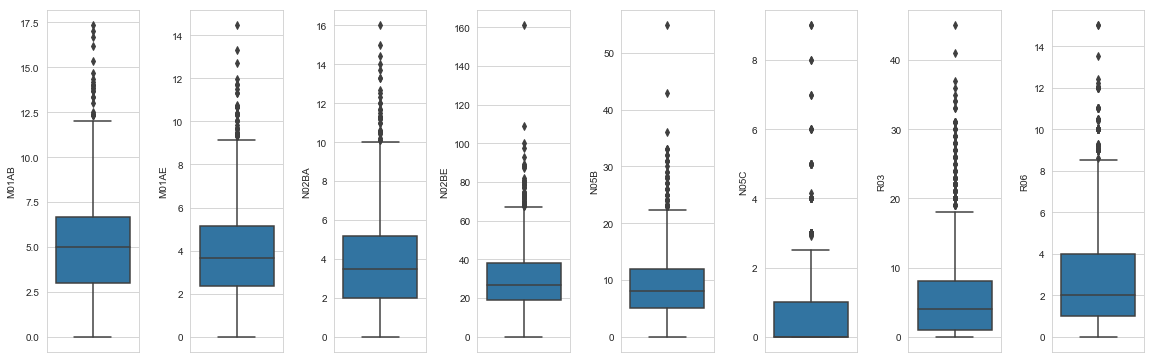

In [32]:
l = df[cols].columns.values
number_of_columns=25
number_of_rows = len(l)-1/number_of_columns
plt.figure(figsize=(2*number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.boxplot(df[l[i]],orient='v')
#     sns.distplot(df[l[i]], kde=True)
    plt.tight_layout()

<Figure size 144x72 with 0 Axes>

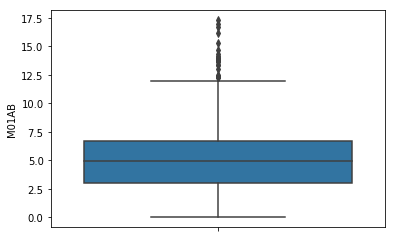

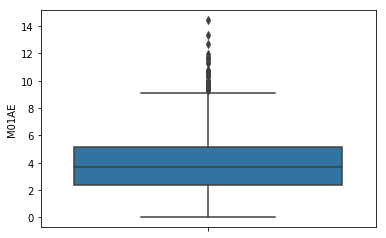

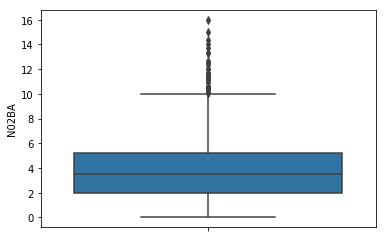

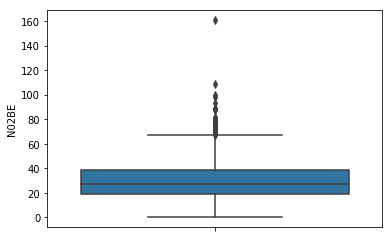

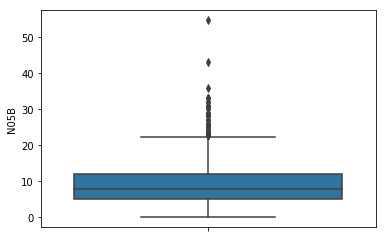

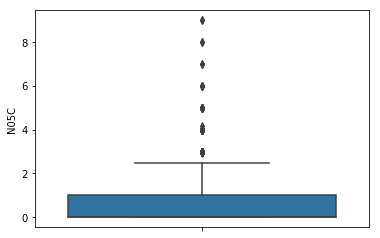

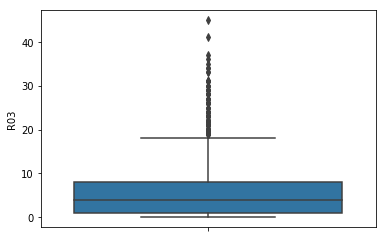

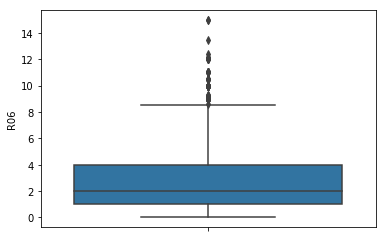

In [13]:
# select ATC categories
cols = ['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06']

plt.figure(figsize=(2,1))
for category in cols:
    plt.subplots()
    sns.boxplot(df[category], orient='v');

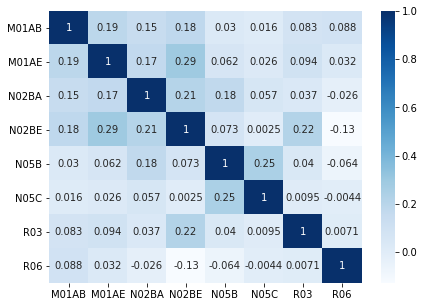

In [262]:
# calculate and show the correlation matrix for categories above
corr = df[cols].corr()
plt.figure(figsize = (7,5))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, annot=True, cmap='Blues');

As part of exploratory data analysis sometimes incredibly useful to look at correlation matrix to models tuning or explore data. <br>
On the graph above dark shades represents positive correlation while lighter shades negative.
If you for instance desire use a linear regression for prediction, you have to consider a remove correlated variables with aim to improving forecast accuracy of the model. <br>
In our case we can see lightly correlation between related categories (N05B, N05C and N02BA, N02BE) and interesting assotiation between M01AE, N02BA codes. Defining the reasons of that could be goal of further analysis.

<Figure size 144x72 with 0 Axes>

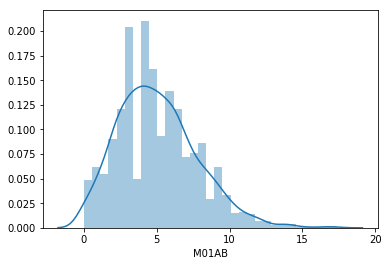

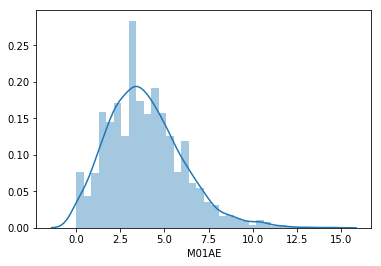

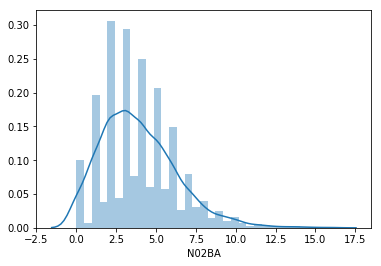

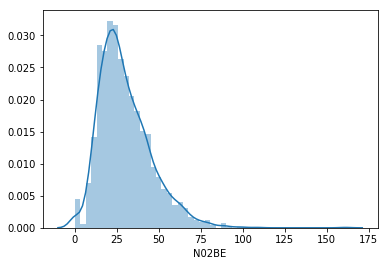

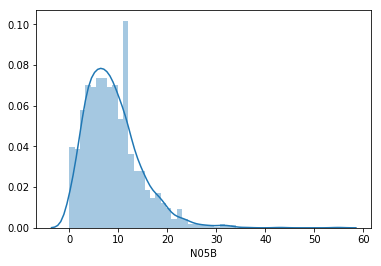

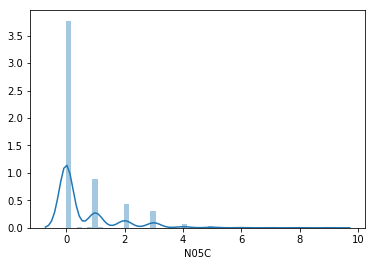

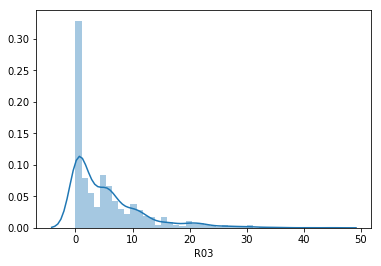

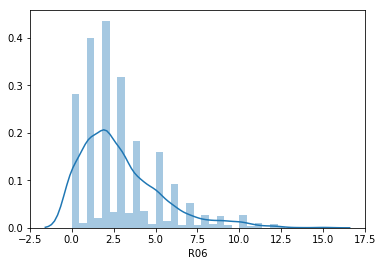

In [296]:
plt.figure(figsize=(2,1))
for category in cols:
    plt.subplots()
    sns.distplot(df[category], kde=True);

Here we see how data is distributed and what are most popular values for each categories.


#### So, let's create a chart bulder function and explore sales dynamic by markets

In [29]:
#grouping ATC codes by types of drugs
atc_codes = {'Antirheumatic' : ['M01AB','M01AE'],
             'Analgesics' : ['N02BA','N02BE'],
             'Psycholeptics' : ['N05C','N05B'],
             'Airway diseases': ['R03'],
             'Antihistamines': ['R06']}

In [213]:
#function that will help us to explore a sales dynamic
def create_charts(data, markets, title, index, freq):
    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(15,5))
    for codes in markets:
        ax.set_title('{} market'.format(title))
        index = data[codes].resample(freq).sum().index
        plt.plot(index, data[codes].resample(freq).sum())
        register_matplotlib_converters()
        plt.legend();

In [193]:
df['datum'] = pd.to_datetime(df['datum'])
df = df.set_index('datum')

#### Now we are ready to observe how sales changes

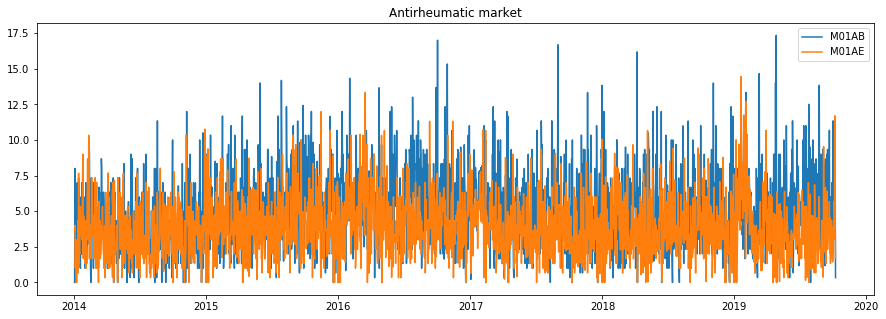

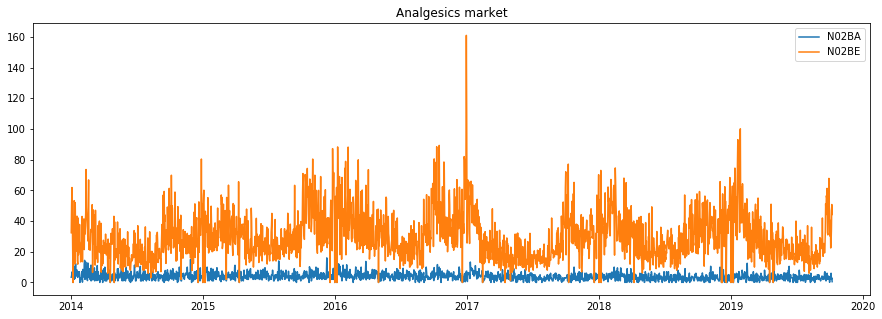

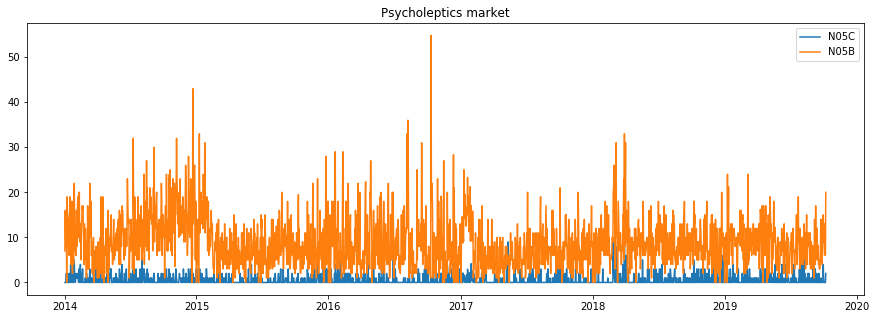

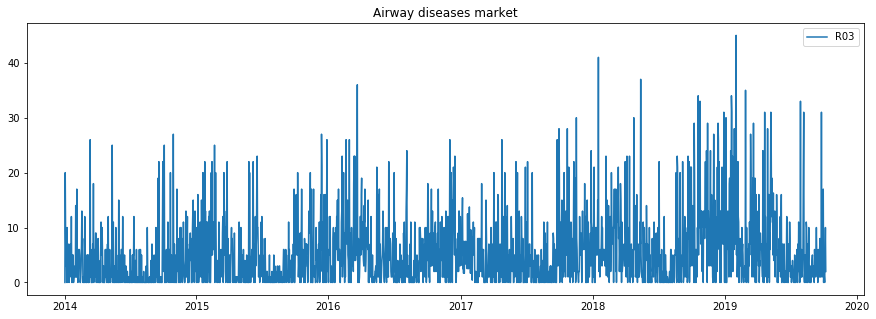

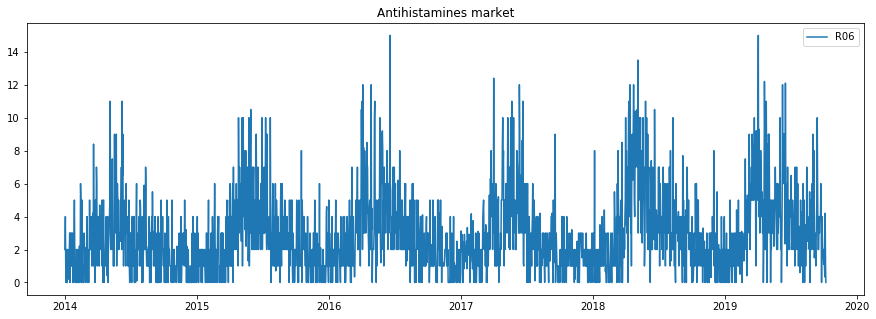

In [214]:
for market in atc_codes.items():
    create_charts(df, market[1], market[0], df.index, 'D')

Easy to see a clear seasonality of sales of antihistamines and analgesics products.<br>
Also, on the first sight, sales of antirheumatic drugs can seems a quite stationary <br>
However, let's look at monthly sales, without highly frequency of daily data

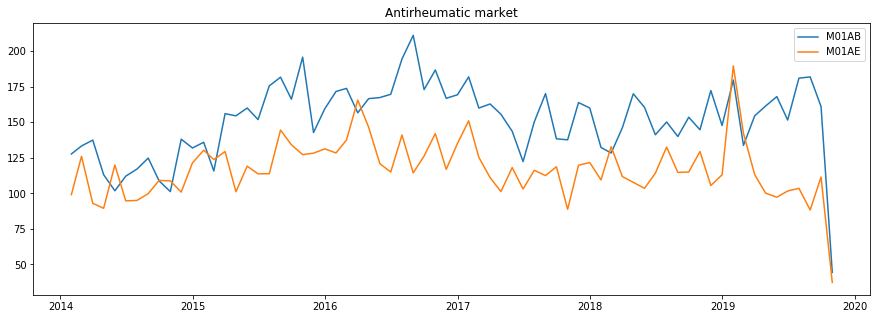

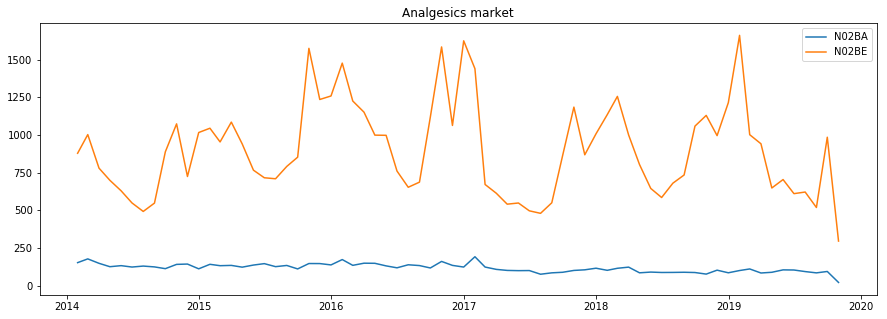

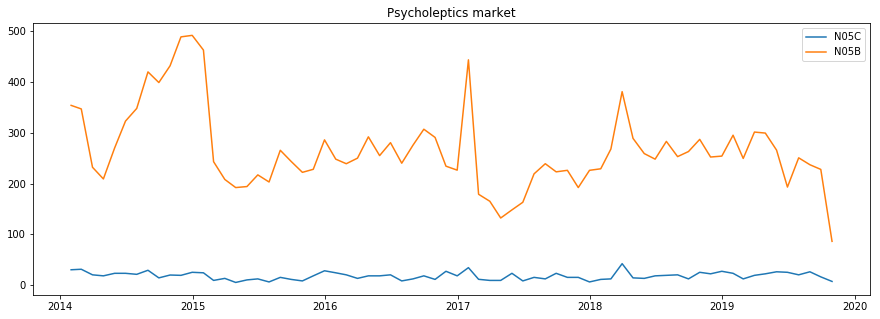

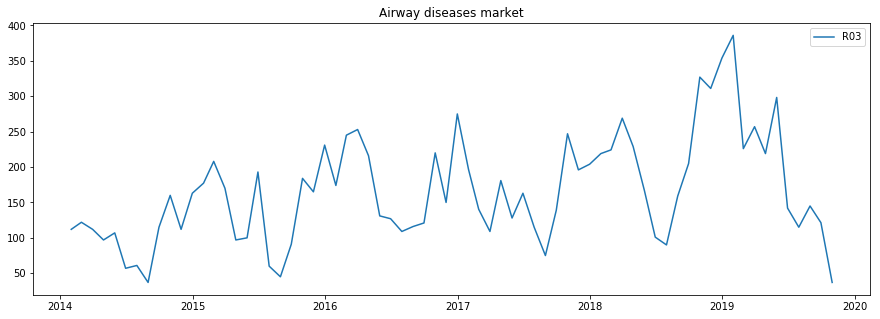

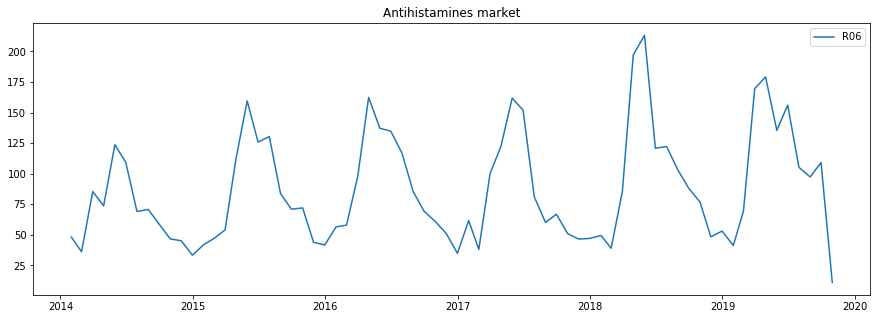

In [219]:
for market in atc_codes.items():
    create_charts(df, market[1], market[0], df.index, 'M')

Great! Now data is much more readable and we can see that all of the markets except one have a seasonality<br>
You also can notice an increasing amount of sales during 2015 year on psycholeptics market and sharp decline then<br>
Sales of the airway disease market additionally except seasonality includes an improving trend



### For the further analysis and prediction modeling choose one market

In [224]:
data = df[atc_codes['Analgesics']].copy()

In [226]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2106 entries, 2014-01-02 to 2019-10-08
Data columns (total 2 columns):
N02BA    2106 non-null float64
N02BE    2106 non-null float64
dtypes: float64(2)
memory usage: 49.4 KB
